## Active Perception for Focused Transmit Steering

### Setup

In [71]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import keras
import keras.ops as ops
import jax
from tqdm import tqdm
from zea import log, init_device
from zea.models.diffusion import DiffusionModel
from zea.ops import Pipeline, ScanConvert
from zea.data import Dataset
from zea.visualize import plot_image_grid, set_mpl_style
from zea.agent.selection import GreedyEntropy
from zea.utils import translate
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [3]:
init_device()
set_mpl_style()

-------------------GPU settings-------------------
     memory
GPU        
0       11011
1       11011
2         848
3       11011
4       11011
5         700
6         848
7         690
Selecting 1 GPU based on available memory.
Selected GPU 0 with Free Memory: 11011.00 MiB


Hiding GPUs [1, 2, 3, 4, 5, 6, 7] from the system.
--------------------------------------------------


### Load Model

In [4]:
model = DiffusionModel.from_preset("diffusion-echonet-dynamic")

### Load dataset

In [5]:
dataset = Dataset("hf://zeahub/camus-sample/val", key="image")

data = dataset[0]["data"]["image"]

img_shape = model.input_shape[:2]

data = keras.ops.expand_dims(data, axis=-1)
data = keras.ops.image.resize(data, img_shape)
dynamic_range = (-40, 0)
data = keras.ops.clip(data, dynamic_range[0], dynamic_range[1])
data = translate(data, dynamic_range, (-1, 1))

zea: Using pregenerated dataset info file: /home/devcontainer20/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/dataset_info.yaml ...
zea: ...for reading file paths in /home/devcontainer20/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val
zea: Dataset was validated on June 12, 2025
zea: Remove /home/devcontainer20/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag if you want to redo validation.


In [6]:
pipeline = Pipeline([ScanConvert(order=1, jit_compile=False)])
parameters = {
    "theta_range": [-0.78, 0.78],  # [-45, 45] in radians
    "rho_range": [0, 1],
}
parameters = pipeline.prepare_parameters(**parameters)


In [ ]:
data_sc = pipeline(data=keras.ops.squeeze(data, axis=-1), **parameters)["data"]

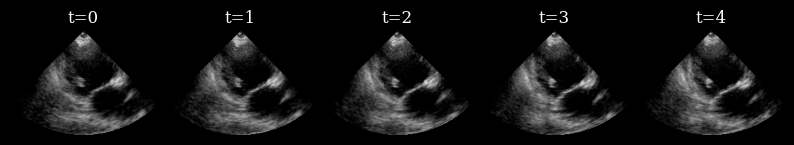

In [ ]:
n_frames_to_plot = 5
fig, _ = plot_image_grid(
    data_sc[:n_frames_to_plot],
    titles=[f"t={t}" for t in range(n_frames_to_plot)],
    ncols=n_frames_to_plot,
    remove_axis=True,
    vmin=-1,
    vmax=1,
)

### Simulate Focused Line Acquisition

In [9]:
def simulate_acquisition(full_frame, mask):
    measurement = full_frame[None,...,0] * mask
    return measurement[...,None], mask[..., None]

### Perception-Action Loop

Initially, we have not yet acquired any measurements, so we draw samples from the prior to drive our actions.

In [76]:
prior_samples = model.sample(n_samples=4, n_steps=90, verbose=True)

90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step


In [77]:
scan_converted_prior_samples = pipeline(data=keras.ops.squeeze(prior_samples, axis=-1), **parameters)["data"]

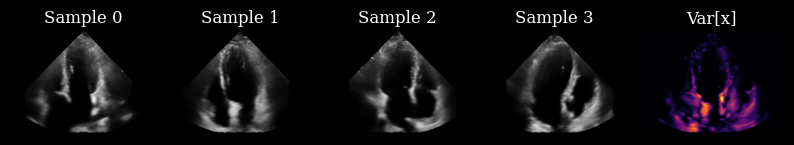

In [78]:
n_prior_samples = len(scan_converted_prior_samples)
posterior_variance = ops.nan_to_num(ops.var(scan_converted_prior_samples, axis=0))
fig, _ = plot_image_grid(
    list(scan_converted_prior_samples) + [translate(posterior_variance, (ops.min(posterior_variance), ops.max(posterior_variance)), (-1, 1))],
    titles = [f"Sample {i}" for i in range(n_prior_samples)] + ["Var[x]"],
    vmin=-1,
    vmax=1,
    cmap=["gray"]*n_prior_samples + ["inferno"]
)

In [83]:
# posterior_sample_jitted = jax.jit(model.posterior_sample, static_argnames=["n_samples", "n_steps", "omega", "initial_step"])

frame_height, frame_width, _ = model.input_shape
action_selector = GreedyEntropy(
    n_actions = 14, # acquire 25% of measurements
    n_possible_actions= frame_width,
    img_width = frame_width,
    img_height = frame_height
)

# select the first actions based on the prior samples
prior_samples_batched = ops.expand_dims(prior_samples[...,0], axis=1)
selected_lines, measurement_mask = action_selector.sample(prior_samples_batched)
# initialise the previous samples as the prior samples
previous_samples = prior_samples

reconstructions = []
measurements = []
for target_frame in tqdm(data):
    # perception
    measurements_t, measurement_mask_t = simulate_acquisition(target_frame, measurement_mask)
    posterior_samples = model.posterior_sample(
        measurements = measurements_t,
        mask = measurement_mask_t,
        initial_samples = previous_samples,
        n_samples = 4,
        n_steps = 200,
        omega=10,
        initial_step=180,
    )

    # action
    selected_lines, measurement_mask = action_selector.sample(ops.transpose(posterior_samples, (1, 0, 2, 3, 4))[..., 0])

    # gather the selected measurements and reconstructions for visualization
    reconstructions.append(posterior_samples[0])
    measurements.append(measurements_t)
    # reset the previous_samples
    previous_samples = posterior_samples

100%|██████████| 17/17 [03:25<00:00, 12.12s/it]


In [84]:
# postprocess outputs
reconstructions = ops.convert_to_tensor(reconstructions)
measurements = ops.convert_to_tensor(measurements)
selected_reconstructions = reconstructions[:,0,...] # choose first sample for each frame to display
reconstructions_sc = pipeline(data=keras.ops.squeeze(selected_reconstructions, axis=-1), **parameters)["data"]
measurements_sc = pipeline(data=keras.ops.squeeze(measurements[:,0,...], axis=-1), **parameters)["data"]
variances_sc = pipeline(data=keras.ops.squeeze(ops.var(reconstructions, axis=1), axis=-1), **(parameters | {"fill_value": 0.0}))["data"]
variances_sc = translate(variances_sc, (ops.min(variances_sc), ops.max(variances_sc)), (-1, 1))

In [90]:

fig, ims = plot_image_grid(
    [data_sc[0], measurements_sc[0], reconstructions_sc[0], variances_sc[0]],
    titles=["Target", "Measurements", "Reconstruction", "Variance"],
    ncols=4,
    vmin=-1,
    vmax=1,
    cmap=["gray"] * 3 + ["inferno"],
    figsize=(8, 3)
)


def update(frame):
    ims[0].set_array(data_sc[frame])
    ims[1].set_array(measurements_sc[frame])
    ims[2].set_array(reconstructions_sc[frame])
    ims[3].set_array(variances_sc[frame])

    return ims

ani = animation.FuncAnimation(fig, update, frames=len(data_sc), blit=True, interval=100)
plt.close(fig)
HTML(ani.to_jshtml())
